In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import seaborn as sb

In [26]:
import os
import io
from google.colab import files
uploaded = files.upload()

Saving drug200.csv to drug200.csv


In [27]:
df= pd.read_csv(io.BytesIO(uploaded['drug200.csv']))

In [28]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [ ]:
encoder = OneHotEncoder()
df_dummy = pd.DataFrame(encoder.fit_transform(df[['Sex']]).toarray())
df = pd.concat([df, df_dummy], axis=1).drop(['Sex'], axis=1)
df.rename(columns={0: "Female", 1: "Male"}, inplace=True)

df['BP'] = pd.np.where(df['BP'] == 'HIGH', 2, 
                       pd.np.where(df['BP'] == 'NORMAL', 1, 0))
df['Cholesterol'] = pd.np.where(df['Cholesterol'] == 'HIGH', 1, 0)
df['Drug'] = df['Drug'].apply(str.lower)

In [30]:
features = ['Age', 'BP', 'Cholesterol', 'Na_to_K', 'Female', 'Male']
target = ['Drug']

X = df[features]
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

y = df[target]
encoder = OneHotEncoder()
y = pd.DataFrame(encoder.fit_transform(y).toarray())

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1)

In [31]:
BATCH_SIZE = 4
SHUFFLE_BUFFER_SIZE = 50

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = test_dataset.batch(BATCH_SIZE)

In [32]:
class dl_model(tf.keras.Model):
    
    def __init__(self, num_classes):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', input_shape=(6,))
        self.outputs = tf.keras.layers.Dense(units=num_classes, activation='softmax')
        
    def call(self, input_tensor, training=False):
        x = self.dense1(input_tensor)
        x = self.outputs(x)
        return x

In [33]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.01)
LOSS = tf.keras.losses.CategoricalCrossentropy()
METRIC = tf.keras.metrics.CategoricalAccuracy()
MODEL = dl_model(num_classes=5)
VAL_METRIC = tf.keras.metrics.CategoricalAccuracy()

In [34]:
def gradients(X, y, model, loss_obj, optimizer):
    with tf.GradientTape() as tape:
        # prediction
        prediction = model(X)
        # calculate the loss
        loss = loss_obj(y, prediction)
    # compute the gradient of the loss with respect to the model weights
    gradient = tape.gradient(loss, model.trainable_weights)
    # apply the gradient to update the weights
    optimizer.apply_gradients(zip(gradient, model.trainable_weights))
    
    return prediction, loss

In [35]:
# function to train 1 step ahead

def train_step(train_dataset, optimizer, model, metric_obj, loss_obj):
    # empty list to store losses
    losses = []
    # progress bar
    pbar = tqdm(total=len(list(enumerate(train_dataset))),
                position=0,
                leave=True,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    # loss over each batch
    for step, (X_batch, y_batch) in enumerate(train_dataset):
        # calculate prediction and loss
        prediction, loss = gradients(X_batch, y_batch, model, loss_obj, optimizer)
        # add the loss to losses
        losses.append(loss)
        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss)))
        pbar.update()
        # calculate the metric
        metric_obj(y_batch, prediction)
    return losses

In [36]:
# function to validate the result

def validation_step(validation_dataset, model, loss_obj, metric):
    # empty list to store losses
    losses = []
    # loop over the validation dataset
    for (X, y) in validation_dataset:
        # prediction
        prediction = model.predict(X)
        # loss
        loss = loss_obj(y, prediction)
        # add the loss to losses
        losses.append(loss)
        # calculate the metric, accuracy in this case
        validation_accuracy = metric(y, prediction)
    return losses

In [37]:
def train(train_dataset, validation_dataset, epochs, model, optimizer,
          loss_obj, train_metric_obj, validation_metric_obj):
    # list to store losses and accuracy
    history_train_losses = []
    history_train_accuracies = []
    history_validation_losses = []
    history_validation_accuracies = []
    
    # loop for epochs
    for epoch in range(epochs):
        # compute train loss, the mean of the losses, and the metric (accuracy in this case)
        train_losses = train_step(train_dataset, optimizer,
                                  model, train_metric_obj, loss_obj)
        train_losses_mean = np.mean(train_losses)
        history_train_losses.append(float(train_losses_mean))
        train_accuracy = train_metric_obj.result()
        history_train_accuracies.append(float(train_accuracy))
        
        # compute validation loss, the mean of the losses, and the metric (accuracy in this case)
        validation_losses = validation_step(validation_dataset, model, loss_obj,
                                        validation_metric_obj)
        validation_losses_mean = np.mean(validation_losses)
        history_validation_losses.append(float(validation_losses_mean))
        validation_accuracy = validation_metric_obj.result()
        history_validation_accuracies.append(float(validation_accuracy))
        
        print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch+1, float(train_losses_mean), float(validation_losses_mean), float(train_accuracy), float(validation_accuracy)))
        
        # reset metric objects
        train_metric_obj.reset_states()
        validation_metric_obj.reset_states()
        
    return [history_train_losses ,history_train_accuracies, history_validation_losses, history_validation_accuracies]

In [38]:
history = train(train_dataset, validation_dataset, 10, MODEL, OPTIMIZER, LOSS, METRIC, VAL_METRIC)

Training loss for step 33: 1.1639: 100%|██████████| 34/34 


1/1 [==============================] - 0s 30ms/step

 Epoch 1: Train loss: 1.3568  Validation Loss: 1.2344, Train Accuracy: 0.4552, Validation Accuracy 0.4242


Training loss for step 33: 1.3456: 100%|██████████| 34/34 


1/1 [==============================] - 0s 20ms/step

 Epoch 2: Train loss: 1.0868  Validation Loss: 1.0478, Train Accuracy: 0.5000, Validation Accuracy 0.5152


Training loss for step 33: 0.7599: 100%|██████████| 34/34 


1/1 [==============================] - 0s 25ms/step

 Epoch 3: Train loss: 0.8774  Validation Loss: 0.8683, Train Accuracy: 0.6567, Validation Accuracy 0.6212


Training loss for step 33: 1.1390: 100%|██████████| 34/34 


1/1 [==============================] - 0s 22ms/step

 Epoch 4: Train loss: 0.7281  Validation Loss: 0.7499, Train Accuracy: 0.7687, Validation Accuracy 0.7879


Training loss for step 33: 0.4462: 100%|██████████| 34/34 


1/1 [==============================] - 0s 22ms/step

 Epoch 5: Train loss: 0.5768  Validation Loss: 0.6433, Train Accuracy: 0.8284, Validation Accuracy 0.8182


Training loss for step 33: 0.5173: 100%|██████████| 34/34 


1/1 [==============================] - 0s 31ms/step

 Epoch 6: Train loss: 0.5010  Validation Loss: 0.5630, Train Accuracy: 0.8657, Validation Accuracy 0.8333


Training loss for step 33: 0.7523: 100%|██████████| 34/34 

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step

 Epoch 7: Train loss: 0.4264  Validation Loss: 0.4766, Train Accuracy: 0.9030, Validation Accuracy 0.8788


Training loss for step 33: 0.2777: 100%|██████████| 34/34 

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step

 Epoch 8: Train loss: 0.3520  Validation Loss: 0.3947, Train Accuracy: 0.9328, Validation Accuracy 0.8939


Training loss for step 33: 0.0522: 100%|██████████| 34/34 


1/1 [==============================] - 0s 19ms/step

 Epoch 9: Train loss: 0.3135  Validation Loss: 0.3988, Train Accuracy: 0.9030, Validation Accuracy 0.8939


Training loss for step 33: 0.1378: 100%|██████████| 34/34 


1/1 [==============================] - 0s 20ms/step

 Epoch 10: Train loss: 0.2713  Validation Loss: 0.3398, Train Accuracy: 0.9701, Validation Accuracy 0.9242


In [39]:
history = pd.DataFrame({'train_losses':history[0],
                        'train_accuracies':history[1],
                        'validation_losses':history[2],
                        'validation_accuracies':history[3],})

history.head()

,train_losses,train_accuracies,validation_losses,validation_accuracies
0,1.356831,0.455224,1.234424,0.424242
1,1.086759,0.500000,1.047815,0.515152
2,0.877384,0.656716,0.868267,0.621212
3,0.728105,0.768657,0.749883,0.787879
4,0.576784,0.828358,0.643306,0.818182


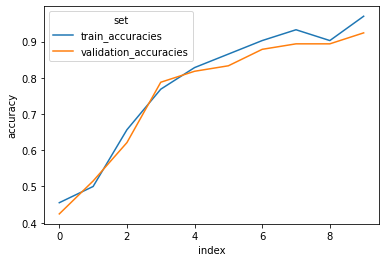

In [40]:
df_viz = history[['train_accuracies', 'validation_accuracies']].reset_index().melt('index', var_name='set',  value_name='accuracy')
sb.lineplot(data=df_viz, x='index', y='accuracy', hue='set')

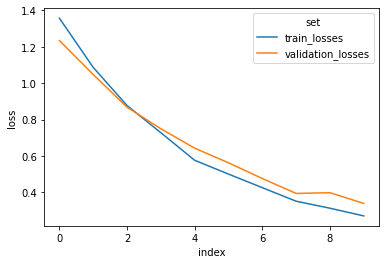

In [41]:
df_viz = history[['train_losses', 'validation_losses']].reset_index().melt('index', var_name='set',  value_name='loss')
sb.lineplot(data=df_viz, x='index', y='loss', hue='set')